This notebook contains code to make figures and undertake analysis for a report on the spread of the variant of concern across the UK.

Author: Verity Hill
(https://github.com/ViralVerity)

In [1]:
import sys

import geopandas
import pandas as pd
from collections import defaultdict
from collections import Counter
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
import scipy.stats
import csv
import matplotlib as mpl

In [2]:
map_data = "../Data/gadm36_GBR_2.json"
eire = geopandas.read_file("../Data/gadm36_IRL_1.json")
ni = geopandas.read_file("../Data/NI_counties.geojson")
level_3 = geopandas.read_file("../Data/gadm36_GBR_3.json")
level_2 = geopandas.read_file(map_data)

level_3 = level_3.to_crs("EPSG:3395")
level_2 = level_2.to_crs("EPSG:3395")

In [7]:
rate_db = pd.read_csv("../Data/growth_rates_UTLANAME_06012021.csv")

####This data is unavailable for use due to data protection issues####
genome_data = "input_data/20210122_Genomes_UTLA_corrected.csv"
#####


figdir = "figures/"
result_dir = "result_files/"

## Make custom location dataframe to match to rate calculations

In [6]:
utla = set(rate_db["prov"])
adm2s = list(level_2["NAME_2"])
adm3s = list(level_3["NAME_3"])

In [7]:
#locations in the rate dataframe that match 1:1 with locations in the GADM dataframe
conversion_dict = {}
conversion_dict["Perth and Kinross"] = "Perthshire and Kinross"
conversion_dict["Kingston upon Hull, City of"] = "Kingston upon Hull"
conversion_dict["St. Helens"] = "Saint Helens"
conversion_dict["Armagh City, Banbridge and Craigavon"] = "Armagh, Banbridge and Craigavon"
conversion_dict["Rhondda Cynon Taf"] = "Rhondda, Cynon, Taff"
conversion_dict["Glasgow City"] = "Glasgow"
conversion_dict["Comhairle nan Eilean Siar"] = "Eilean Siar"
conversion_dict["Bristol, City of"] = "Bristol"
conversion_dict["Dundee City"] = "Dundee"
conversion_dict["Herefordshire, County of"] = "Herefordshire"
conversion_dict["Ards and North Down"] = "North Down and Ards"
conversion_dict["Derry City and Strabane"] = "Derry and Strabane"
conversion_dict["City of Edinburgh"] = "Edinburgh"
conversion_dict["County Durham"] = "Durham"
conversion_dict["Isle of Anglesey"] = "Anglesey"
conversion_dict["Aberdeen City"] = "Aberdeen"
conversion_dict["Hackney and City of London"] = "Hackney"
conversion_dict["Bedford"] = "Bedfordshire"
conversion_dict["Na h-Eileanan Siar"] = "Eilean Siar"

reverse_conversion_dict = {}
for k,v in conversion_dict.items():
     reverse_conversion_dict[v.upper().replace(" ","_")] = k.upper().replace(" ","_")

In [23]:
#GADM locations which need to be merged together
merge_dict = {}
merge_dict["Cornwall"] = "Cornwall and Isles of Scilly"
merge_dict["Isles of Scilly"] = "Cornwall and Isles of Scilly"
merge_dict["Bournemouth"] = "Bournemouth, Christchurch and Poole"
merge_dict["Poole"] = "Bournemouth, Christchurch and Poole"

In [24]:
#These locations are going to be split up, so the larger polygon is removed first
remove_london = level_2.loc[level_2["NAME_2"] != "Greater London"]
remove_lincs = remove_london.loc[remove_london["NAME_2"] != "Lincolnshire"]
remove_sefton = remove_lincs.loc[remove_lincs["NAME_2"] != "Sefton"]

In [25]:
#merge together those locations in the merge dict
for_merging = []

for location in remove_sefton["NAME_2"]:
    if location in merge_dict:
        for_merging.append(merge_dict[location])
    else:
        for_merging.append(location)

remove_sefton["Multi_loc"] = for_merging

merged_locs = remove_sefton.dissolve(by="Multi_loc")

mergeds = []
for multi_loc in merged_locs.index:
    mergeds.append(multi_loc)

merged_locs["NAME_2"] = mergeds 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [26]:
#Get the london boroughs ready
to_add = level_3.loc[level_3["NAME_2"] == "Greater London"]
to_add["NAME_2"] = to_add["NAME_3"]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
#Get lincolnshire components ready
lincs = level_3.loc[level_3["NAME_2"] == "Lincolnshire"]
for_merging = []

for location in lincs["NAME_3"]:
    if location != "North East Lincolnshire":
        for_merging.append("Lincolnshire")
    else:
        for_merging.append(location)

lincs["Multi_loc"] = for_merging

linc_merged_locs = lincs.dissolve(by="Multi_loc")

mergeds = []
for multi_loc in linc_merged_locs.index:
    mergeds.append(multi_loc)

linc_merged_locs["NAME_2"] = mergeds 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [28]:
#Get Sefton/Liverpool ready
sefton = level_3.loc[level_3["NAME_2"] == "Sefton"]
sefton["NAME_2"] = sefton["NAME_3"]
#beds = level_3.loc[level_3["NAME_2"] == "Luton"]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
#Add them all together
custom_df = merged_locs.append(linc_merged_locs).append(sefton).append(to_add)


In [13]:
london_boroughs =  []
for i in level_3.loc[level_3["NAME_2"] == "Greater London"]["NAME_3"]:
    london_boroughs.append(i.upper().replace(" ","_"))

In [30]:
#A quick test to make sure all of locations in the rate dataframe are accounted for
lower_londons = []
for i in london_boroughs:
    lower_londons.append(i.replace("_", " ").title())
new_adm2s = list(custom_df["NAME_2"])
for i in utla:
    if i not in conversion_dict and i not in adm2s and i not in merge_dict.values()  and i not in lower_londons:
        print(i)


Richmond upon Thames
Kensington and Chelsea
Hammersmith and Fulham
Kingston upon Thames
North East Lincolnshire
Barking and Dagenham
Liverpool


## Growth rates across UK

In [31]:
#This is six days before the current date
# cutoff = dt.date(2020,12,8)
# cutoff = dt.date(2020,12,15)
# cutoff = dt.date(2020,12,22)
cutoff = dt.date(2020,12,17)

cutoff_string = cutoff.strftime("%Y-%m-%d")
print(cutoff_string)

#Convert strings to date objects
rate_db['times'] =  pd.to_datetime(rate_db['times']).dt.date
#Remove more recent times to account for reporting lag
new_rates = rate_db.loc[rate_db["times"] < cutoff]


2020-12-17


In [32]:
#Calculate seven day rolling average for each location, and take the most recent value
df_dict = defaultdict(list)

for place in utla:

    first = new_rates.loc[new_rates["prov"] == place]    
    rolling_mean = first.rates.rolling(window=7).mean()
    last_mean = float(rolling_mean.iloc[[-1]])
    
    df_dict["name"].append(place)
    df_dict["Rate"].append(last_mean)

average_rate = pd.DataFrame(df_dict)

In [33]:
#Convert any names that need converting to match the custom dataframe
new_names = []
for place in average_rate["name"]:
    if place in conversion_dict:
        new_name = conversion_dict[place]
    else:
        new_name = place
        
    new_names.append(new_name)
    
average_rate["NAME_2"] = new_names

In [34]:
#Combine the dataframe with shapes with the rates
with_rates = custom_df.merge(average_rate)


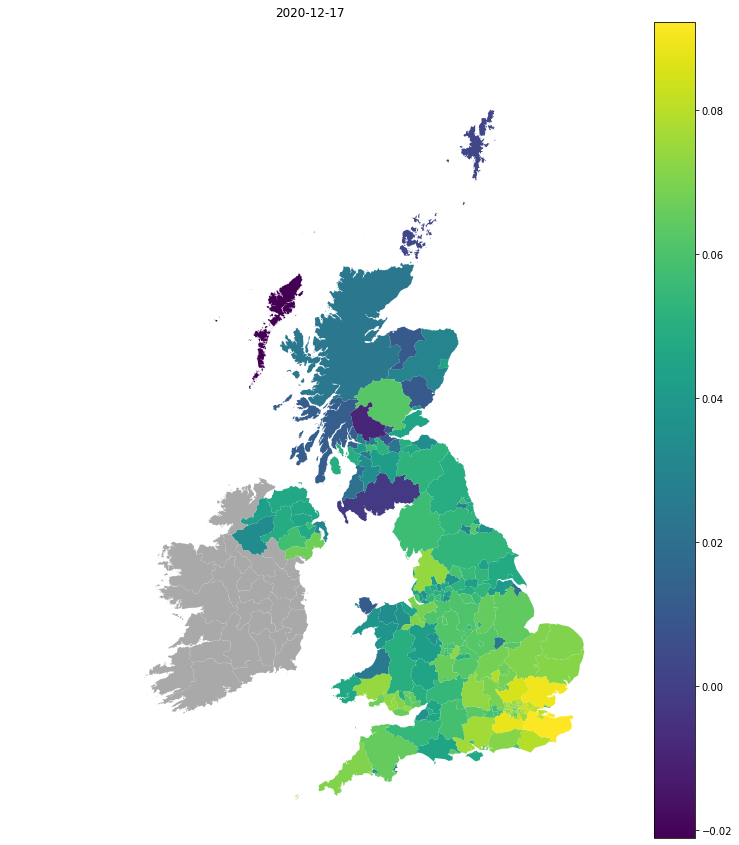

In [107]:
#Plot the rates

fig, ax = plt.subplots(figsize=(15,15))

with_rates = with_rates.to_crs("EPSG:3395")
eire = eire.to_crs("EPSG:3395")

eire["geometry"] = eire.geometry.simplify(1000)
with_rates["geometry"] = with_rates.geometry.simplify(1000)

with_rates.plot(ax=ax, column="Rate", legend=True)
eire.plot(ax=ax, color="darkgrey")

plt.title(cutoff_string)

ax.axis("off")

plt.savefig(f'{figdir}rate_map_{cutoff_string}.png', format='png')
plt.savefig(f'{figdir}rate_map_{cutoff_string}.pdf', format='pdf', dpi=5)

plt.show()

## Map of location where variant is present and when first sample was detected.


In [4]:
aggregates = {}
with open("input_data/adm2_aggregation.csv") as f:
    next(f)
    for l in f:
        toks = l.strip("\n").split(",")
        aggregates[toks[0]] = toks[1]

In [5]:
nice_names = {"BIRMINGHAM|COVENTRY|DUDLEY|SANDWELL|SOLIHULL|WALSALL|WOLVERHAMPTON":"West Midlands",
        "DERBY|DERBYSHIRE|LEICESTER|LEICESTERSHIRE|LINCOLNSHIRE|NORTHAMPTONSHIRE|NOTTINGHAM|NOTTINGHAMSHIRE|RUTLAND":"East Midlands",
        "BOLTON|BURY|MANCHESTER|OLDHAM|ROCHDALE|SALFORD|STOCKPORT|TAMESIDE|TRAFFORD|WIGAN":"Greater Manchester",
        "EAST_SUSSEX|WEST_SUSSEX":"Sussex",
        "BRADFORD|CALDERDALE|KIRKLEES|LEEDS|WAKEFIELD":"West Yorkshire",
        "GATESHEAD|NEWCASTLE_UPON_TYNE|NORTH_TYNESIDE|SOUTH_TYNESIDE|SUNDERLAND": "Tyne and Wear",
        "BARNSLEY|DONCASTER|ROTHERHAM|SHEFFIELD": "South Yorkshire",
        "BRACKNELL_FOREST|READING|SLOUGH|WEST_BERKSHIRE|WINDSOR_AND_MAIDENHEAD|WOKINGHAM":"Berkshire",
        "BRACKNELL_FOREST|BUCKINGHAMSHIRE|READING|SLOUGH|WEST_BERKSHIRE|WINDSOR_AND_MAIDENHEAD|WOKINGHAM":"Berkshire and Buckinghamshire",
        'KNOWSLEY|SAINT_HELENS|SEFTON|WIRRAL':"Merseyside",
        "CHESHIRE_EAST|CHESHIRE_WEST_AND_CHESTER":"Cheshire",
        "RHONDDA_CYNON_TAFF": "RHONDDA,_CYNON,_TAFF"
             }

In [8]:
#Pull out the genomic data
#Two sequences required additional cleaning, and two sequences had locations which were too ambiguous, so these were left out
count = 0
location_to_dates = defaultdict(list)
with open(genome_data) as f:
    data = csv.DictReader(f)
    for line in data:
        date = dt.datetime.strptime(line["sample_date"], "%Y-%m-%d").date()
        loc = line["adm2"]
        if line["lineage"] == "B.1.1.7":
            if loc != "" and loc != "Needs_manual_curation" and loc != "THURROCK|GREATER_LONDON|KENT" and loc != "THURROCK|KENT|MEDWAY":
                if "|" in loc and loc not in nice_names.keys():
                    new_name = ""
                    bits = loc.split("|")
                    for i in bits:
                        if i in aggregates:
                            next_bit = aggregates[i]
                        else:
                            next_bit = i
                        if len(new_name) == 0:
                            new_name += next_bit
                        else:
                            new_name += "|" + next_bit
                elif loc in nice_names.keys():
                    new_name = nice_names[loc].upper().replace(" ","_")
                elif "|" not in loc and loc in aggregates:
                    new_name = aggregates[loc].upper().replace(" ","_")
#                     if "EAST_SUSSEX" in loc:
#                         print(loc, new_name)
                else:
                    new_name = loc

                final_name = ""
                if "|" in new_name:
                    name_lst = []
                    name_lst.extend(new_name.split("|"))
                    name_set = set(name_lst)
                    if len(name_set) == 1:
                        final_name = list(name_set)[0]
                    else:
                        pass
                else:
                    final_name = new_name
                
                if final_name != "":
                    location_to_dates[final_name].append(date)


In [9]:
#OLD 
#Deal with sequence locations that are combinations of GADM adm2s 
#These are mostly commonly used aggregations like Merseyside that we split up to ease matching sequences to shapefiles.
#The adm2 cleaning step that provides input for this step is a product of the grapevine pipeline which is run every day 

#Find all the ambiguities and their component parts
ambiguous = []
ambiguous_dict = defaultdict(set)
clusters = []

for adm2 in location_to_dates.keys():
    if "|" in adm2:
        ambiguous.append(frozenset(adm2.split("|")))

amb_set = set(ambiguous)

for group in amb_set:
    for group2 in amb_set:
        if group != group2:
            if group & group2:
                group |= group2
    for group2 in amb_set:
        if group != group2:
            if group & group2:
                group |= group2

    clusters.append(group)

for cluster in clusters:
    for place in cluster:
        ambiguous_dict[place] = "|".join(sorted(cluster))

        
#Merge the dates together into the new merged locations
newlocation_to_dates = defaultdict(list)
for key, value in location_to_dates.items():
    if "|" in key:
        lookup = key.split("|")[0]
        new_loc = ambiguous_dict[lookup] 
    else:
        if key in ambiguous_dict:
            new_loc = ambiguous_dict[key]
        else:
            new_loc = key
    newlocation_to_dates[new_loc].extend(value)

In [10]:
#Find the earliest date of each new location
loc_to_earliest = defaultdict(list)
all_earliest = []
for k,v in newlocation_to_dates.items():
    all_earliest.append(min(v))

count = 0
date_to_num = {}
num_to_date = {}
one_day = dt.timedelta(1)
day_range = (max(all_earliest) - min(all_earliest)).days
date = min(all_earliest)
for num in range(day_range+1):
    date_to_num[date] = num
    num_to_date[num] = date
    date += one_day
    
    
    
for k,v in location_to_dates.items():
    loc_to_earliest["NAME_2"].append(k)
    loc_to_earliest["earliest_date"].append(min(v))
    loc_to_earliest["date_number"].append(date_to_num[min(v)])
    
earliest_date = pd.DataFrame(loc_to_earliest)
earliest_date.to_csv(result_dir + "variant_present.csv")

In [11]:
#Merge the shape files together
ambiguous_dict = aggregates
for_merging = []

for location in level_2["NAME_2"]:
    if location.upper().replace(" ","_") in ambiguous_dict:
        for_merging.append(ambiguous_dict[location.upper().replace(" ","_")])
    else:
        for_merging.append(location.upper().replace(" ","_"))
        
level_2["Multi_loc"] = for_merging

level_2_merged = level_2.dissolve(by="Multi_loc")

mergeds = []
for multi_loc in level_2_merged.index:
    mergeds.append(multi_loc)

level_2_merged["NAME_2"] = mergeds 

In [12]:
correct_crs = level_2_merged.to_crs("EPSG:4326")
correct_crs

correct_crs.to_file("merged_adm2_NI_districts.shp")

In [13]:
# Remove Northern Ireland LADs and replace with counties to match with sequence data
no_ni = level_2_merged.loc[level_2_merged["NAME_1"] != "Northern Ireland"]

ni["NAME_2"] = ni["CountyName"]
ni = ni.to_crs("EPSG:3395")
ni_fixed = no_ni.append(ni)

In [14]:
print(ni.crs)

EPSG:3395


In [15]:
with_earliest = ni_fixed.merge(earliest_date, how="outer")

In [20]:
#get present/more than one here
with_earliest.loc[with_earliest["earliest_date"].isnull()]

for k,v in location_to_dates.items():
    if len(v) == 1:
        print(k)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator


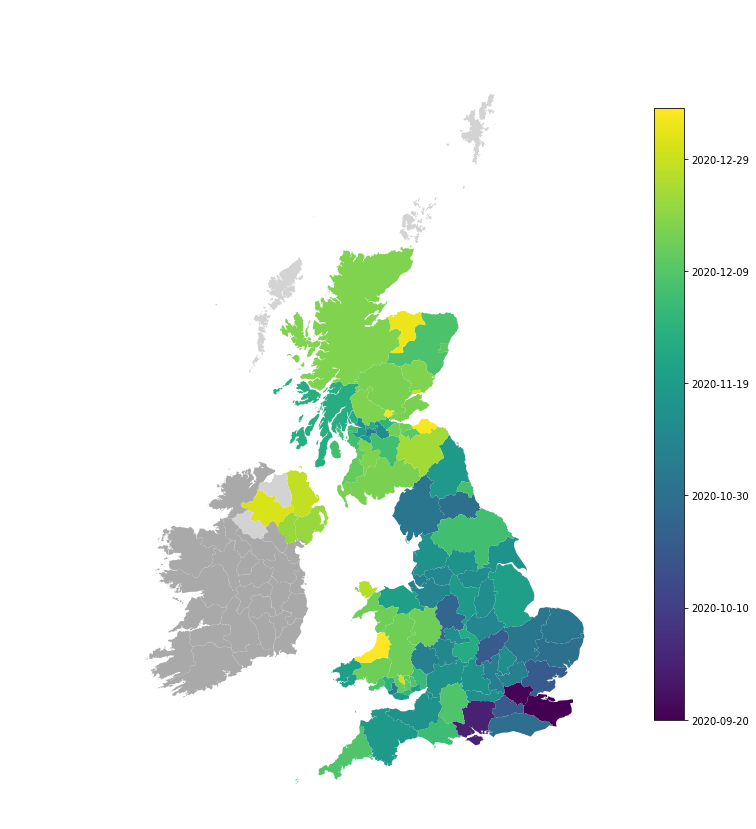

In [45]:
#Plot the results

mpl.rcParams["path.simplify"] = True
mpl.rcParams["path.simplify_threshold"] = 1.0

fig, ax = plt.subplots(figsize=(15,15))

with_earliest = with_earliest.to_crs("EPSG:3395")
eire = eire.to_crs("EPSG:3395")

eire["geometry"] = eire.geometry.simplify(1000)
with_earliest["geometry"] = with_earliest.geometry.simplify(1000)

with_earliest.plot(ax=ax, cmap='viridis', legend=True, column="date_number", legend_kwds={"shrink":0.75},
                   missing_kwds={"color": "lightgrey","label": "No variant recorded"})
eire.plot(ax=ax, color="darkgrey")

colourbar = ax.get_figure().get_axes()[1]
yticks = colourbar.get_yticks()

colourbar.set_yticklabels([num_to_date[ytick] for ytick in yticks])
    

ax.axis("off")

plt.savefig(figdir + "variant_first_date.png", format='png')
plt.savefig(figdir + "variant_first_date.pdf", format='pdf')

plt.show()

### Converting to utla for ease of comparison

In [80]:
utla_list = []
for i in utla:
    utla_list.append(i.upper().replace(" ","_"))

In [95]:
adm2_names = []
for name in box_df["location"]:
    adm2_names.append(name)
    
utla_names = {}
for name in adm2_names:
    new_name = []
    if "|" in name:
        toks = name.split("|")
        for i in toks:
            if i in reverse_conversion_dict:
                new_name.append(reverse_conversion_dict[i])
            elif i in utla_ambig2:
                new_name.extend(utla_ambig2[i].split("|"))
            else:
                new_name.append(i)
                if i not in utla_list:
                    print(i)

    else:
        if name in reverse_conversion_dict:
            new_name.append(reverse_conversion_dict[name])
        elif name in utla_ambig2:
            new_name.extend(utla_ambig2[name].split("|"))
        else:
            new_name.append(name)
            if name not in utla_list:
                print(name)
            
    final = "|".join(new_name)
    
    utla_names[name] = final
    


In [100]:
df_dict = defaultdict(list)

for k,v in utla_names.items():
    df_dict["location"].append(k)
    df_dict["utla"].append(v)
    if k in newlocation_to_dates:
        df_dict["earliest_sequence"].append(min(newlocation_to_dates[k]))
    else:
        df_dict["earliest_sequence"].append("NA")
    
    
utla_df = pd.DataFrame(df_dict)

box_df.merge(utla_df)
    
box_df.to_csv("utla_earliest_seq_rate.csv")

In [96]:
#Some descriptive measures

print(len(newlocation_to_dates))
small_locs = []
count = 0
for i,v in newlocation_to_dates.items():
    if len(v) <=5:
        small_locs.append(i)
    else:
        count += 1
        
print(count)
print(len(small_locs))

60
30
30


## Frequency calculation (early late and updated)

In [21]:
all_dates = []
with open("all_dates_locs_updated.csv") as f:
    next(f)
    for l in f:
        toks = l.strip("\n").split(",")
        date = dt.datetime.strptime(toks[0], "%Y-%m-%d").date()
        if toks[1] == "UK":
            all_dates.append(date)
            
print(max(all_dates))

2020-12-21


In [31]:
count = 0
for i in all_dates:
    if i > dt.date(2020,12,17):
        count += 1
print(count)

212


In [54]:
all_locs_to_dates_early = defaultdict(list)
all_locs_to_dates_late = defaultdict(list)
all_locs_to_dates_latest = defaultdict(list)

all_locs_to_dates = defaultdict(list)

early_start = dt.date(2020,11,25)
early_finish = dt.date(2020,12,2)

late_start = dt.date(2020,12,10)
late_finish = dt.date(2020,12,17)

later_start = dt.date(2020,12,18)
later_finish = dt.date(2020,12,21)

with open("all_dates_locs_updated.csv") as f:
    next(f)
    for l in f:
        toks = l.strip("\n").split(",")
        date = dt.datetime.strptime(toks[0], "%Y-%m-%d").date()
        if toks[1] == "UK":
            if toks[2] != "" and toks[2] != "Needs_manual_curation":
                if date >= early_start and date <= early_finish:
                    all_locs_to_dates_early[toks[2]].append(date)
                    all_locs_to_dates[toks[2]].append(date)
                if date >= late_start and date <= late_finish:
                    all_locs_to_dates_late[toks[2]].append(date)
                    all_locs_to_dates[toks[2]].append(date)
                if date >= later_start and date <= later_finish:
                    all_locs_to_dates_latest[toks[2]].append(date)
                    all_locs_to_dates[toks[2]].append(date)

elephants_early = defaultdict(list)
elephants_late = defaultdict(list)
elephants_latest = defaultdict(list)

for k,v in location_to_dates.items():
    lst_early = []
    lst_late = []
    lst_later = []
    for i in v:
        if i >= early_start and i <= early_finish:
            lst_early.append(i)
        if i >= late_start and i <= late_finish:
            lst_late.append(i)
        if i >= later_start and i <= later_finish:
            lst_later.append(i)
    
    if len(lst_early) != 0 or len(lst_late) != 0 or len(lst_later) != 0:
        elephants_early[k] = lst_early
        elephants_late[k] = lst_late
        elephants_latest[k] = lst_later

In [56]:
def make_merged_locations(input_dict):
    output_dict = defaultdict(list)
    for key, value in input_dict.items():
        if "|" in key:
            lookup = key.split("|")[0]
            new_loc = ambiguous_dict[lookup] 
        else:
            if key in ambiguous_dict:
                new_loc = ambiguous_dict[key]
            else:
                new_loc = key
        output_dict[new_loc].extend(value)
    return output_dict


In [65]:
#Find all the ambiguities and their component parts
ambiguous = []
ambiguous_dict = defaultdict(set)
clusters = []

for adm2 in all_locs_to_dates.keys():
    if "|" in adm2:
        ambiguous.append(frozenset(adm2.split("|")))

amb_set = set(ambiguous)

for group in amb_set:
    for group2 in amb_set:
        if group != group2:
            if group & group2:
                group |= group2
    for group2 in amb_set:
        if group != group2:
            if group & group2:
                group |= group2
    for group2 in amb_set:
        if group != group2:
            if group & group2:
                group |= group2

    clusters.append(group)

for cluster in clusters:
    for place in cluster:
        ambiguous_dict[place] = "|".join(sorted(cluster))

        
#Merge the dates together into the new merged locations
new_locs_early_all = make_merged_locations(all_locs_to_dates_early)
new_locs_late_all = make_merged_locations(all_locs_to_dates_late)
new_locs_later_all = make_merged_locations(all_locs_to_dates_latest)

new_elephants_early = make_merged_locations(elephants_early)
new_elephants_late = make_merged_locations(elephants_late)
new_elephants_latest = make_merged_locations(elephants_latest)



In [66]:
early_frequencies = {}
late_frequencies = {}
latest_frequencies = {}

for loc, lst in new_elephants_early.items():
    try:
        early_frequencies[loc] = len(lst)/len(new_locs_early_all[loc])
    except ZeroDivisionError:
        early_frequencies[loc] = 0
    
for loc, lst in new_elephants_late.items():
    try:
        late_frequencies[loc] = len(lst)/len(new_locs_late_all[loc])
    except ZeroDivisionError:
        late_frequencies[loc] = 0
    
for loc, lst in new_elephants_latest.items():
    try:
        latest_frequencies[loc] = len(lst)/len(new_locs_later_all[loc])
    except ZeroDivisionError:
        latest_frequencies[loc] = 0

In [67]:
df_dict = defaultdict(list)

for k,v in late_frequencies.items():
    df_dict["Location"].append(k)
    df_dict["Early_frequency"].append(early_frequencies[k])
    df_dict["Early_count_all"].append(len(new_locs_early_all[k]))
    df_dict["Early_count_elephants"].append(len(new_elephants_early[k]))
    df_dict["Late_frequency"].append(v)
    df_dict["Late_count_all"].append(len(new_locs_late_all[k]))
    df_dict["Late_count_elephants"].append(len(new_elephants_late[k]))
    df_dict["Later_frequency"].append(latest_frequencies[k])
    df_dict["Later_count_all"].append(len(new_locs_later_all[k]))
    df_dict["Later_count_elephants"].append(len(new_elephants_latest[k]))
    
                                      
                                      
freq_df = pd.DataFrame(df_dict)
freq_df.to_csv("Early_and_late_and_later_frequencies.csv")